# ACOL replication tensorflow

## Setup stuff

In [29]:
import smtplib
from email.mime.text import MIMEText
import random

#imports and settings:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from jupyterthemes import jtplot
from sklearn.cluster import KMeans
from scipy.stats import threshold
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.contrib.learn.python.learn.datasets import mnist
#jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

local_file = base.maybe_download(TRAIN_IMAGES, './MNIST_data',
                                   SOURCE_URL + TRAIN_IMAGES)
with open(local_file, 'rb') as f:
    train_images = mnist.extract_images(f)
    
local_file = base.maybe_download(TRAIN_LABELS, './MNIST_data',
                                   SOURCE_URL + TRAIN_LABELS)
with open(local_file, 'rb') as f:
    train_labels = mnist.extract_labels(f, one_hot=True)

local_file = base.maybe_download(TEST_IMAGES, './MNIST_data',
                                   SOURCE_URL + TEST_IMAGES)
with open(local_file, 'rb') as f:
    test_images = mnist.extract_images(f)

local_file = base.maybe_download(TEST_LABELS, './MNIST_data',
                                   SOURCE_URL + TEST_LABELS)
with open(local_file, 'rb') as f:
    test_labels = mnist.extract_labels(f, one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [30]:
def notify(body):
    msg = MIMEText(body)
    # me == the sender's email address
    # you == the recipient's email address
    msg['Subject'] = 'Finished training!'
    msg['From'] = "scriptnotificiations@gmail.com"
    msg['To'] = "scriptnotificiations@gmail.com"

    # Send the message via our own SMTP server, but don't include the
    # envelope header.
    s = smtplib.SMTP('smtp.gmail.com', 587)
    s.starttls()
    s.login("scriptnotificiations@gmail.com", "SuperSecretMegaPassword!!!")
    s.sendmail("scriptnotificiations@gmail.com", ["scriptnotificiations@gmail.com"], msg.as_string())
    s.quit()

In [31]:
clustCount = 5
classCount = 2
net = 0
trainsteps = 30000

perc = 0.01
balance=True

validation_size=5000
_epochs_completed_train = 0
_index_in_epoch_train = 0
_epochs_completed_val = 0
_index_in_epoch_val = 0
_epochs_completed_test = 0
_index_in_epoch_test = 0

In [32]:
y = {0:[1,0],
     1:[1,0],
     2:[1,0],
     3:[1,0],
     4:[1,0],
     5:[0,1],
     6:[0,1],
     7:[0,1],
     8:[0,1],
     9:[0,1]}
y2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}
y2[0][0,0] = 1
y2[1][0,1] = 1
y2[2][0,2] = 1
y2[3][0,3] = 1
y2[4][0,4] = 1
y2[5][1,0] = 1
y2[6][1,1] = 1
y2[7][1,2] = 1
y2[8][1,3] = 1
y2[9][1,4] = 1

emptyy2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}

In [33]:
train_super_labels = np.array([y[np.argmax(train_labels[j])] for j in range(train_labels.shape[0])])
test_super_labels = np.array([y[np.argmax(test_labels[j])] for j in range(test_labels.shape[0])])

train_labels = np.array([y2[np.argmax(train_labels[j])] for j in range(train_labels.shape[0])])
test_labels = np.array([y2[np.argmax(test_labels[j])] for j in range(test_labels.shape[0])])

In [34]:
if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))

validation_images = train_images[:validation_size]
validation_labels = train_labels[:validation_size]
validation_super_labels = train_super_labels[:validation_size]
#validation_labels_clipped = train_labels_clipped[:validation_size]
train_images = train_images[validation_size:]
train_labels = train_labels[validation_size:]
train_super_labels = train_super_labels[validation_size:]
#train_labels_clipped = train_labels_clipped[validation_size:]

train_images = train_images.reshape(train_images.shape[0],train_images.shape[1] * train_images.shape[2])
train_images = train_images.astype(np.float32)
train_images = np.multiply(train_images, 1.0 / 255.0)

validation_images = validation_images.reshape(validation_images.shape[0],validation_images.shape[1] * validation_images.shape[2])
validation_images = validation_images.astype(np.float32)
validation_images = np.multiply(validation_images, 1.0 / 255.0)

test_images = test_images.reshape(test_images.shape[0],test_images.shape[1] * test_images.shape[2])
test_images = test_images.astype(np.float32)
test_images = np.multiply(test_images, 1.0 / 255.0)

print(train_labels.reshape([-1,10]).shape)

trainCount=len(train_images)
if balance:
    inds = []
    classSize = int(np.ceil(trainCount*perc/10))
    for j in range(10):
        inds.extend([i for i, x in enumerate(np.argmax(train_labels.reshape([-1,10]),1)) if x == j][:classSize])
    random.shuffle(inds)

    train_labels_clipped = np.array([train_labels[j,:,:] for j in inds])
    train_labels_clipped = np.concatenate([train_labels_clipped,np.array([emptyy2[np.argmax(train_labels[j])] for j in range(trainCount) if j not in inds])])
else:
    train_labels_clipped = np.array([y2[np.argmax(train_labels[j])] for j in range(int(train_labels.shape[0]*perc))])
    train_labels_clipped = np.concatenate([train_labels_clipped,np.array([emptyy2[np.argmax(train_labels[j])] for j in range(int(train_labels.shape[0]*perc),train_labels.shape[0])])])

print np.unique(np.argmax(train_labels.reshape([-1,10]),1),return_counts=True)

(55000, 10)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5444, 6179, 5470, 5638, 5307, 4987, 5417, 5715, 5389, 5454]))


In [35]:
def next_batch(batch_size, shuffle, images, labels, superlabels, ep_compl, ep_ind):
    _epochs_completed = ep_compl
    _index_in_epoch = ep_ind
    """Return the next `batch_size` examples from this data set."""
    start = _index_in_epoch
    _num_examples = images.shape[0]
    # Shuffle for the first epoch
    if _epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(_num_examples)
      np.random.shuffle(perm0)
      _images = images[perm0]
      _labels = labels[perm0]
      _super_labels = superlabels[perm0]
    # Go to the next epoch
    if start + batch_size > _num_examples:
      # Finished epoch
      _epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = _num_examples - start
      images_rest_part = _images[start:_num_examples]
      labels_rest_part = _labels[start:_num_examples]
      super_labels_rest_part = _super_labels[start:_num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(_num_examples)
        np.random.shuffle(perm)
        _images = images[perm]
        print(_images)
        _labels = labels[perm]
        _super_labels = super_labels[perm]
      # Start next epoch
      start = 0
      _index_in_epoch = batch_size - rest_num_examples
      end = _index_in_epoch
      images_new_part = _images[start:end]
      labels_new_part = _labels[start:end]
      super_labels_new_part = _super_labels[start:end]
      return np.concatenate((images_rest_part, images_new_part), axis=0) , np.concatenate((labels_rest_part, labels_new_part), axis=0), np.concatenate((super_labels_rest_part, super_labels_new_part), axis=0)
    else:
      _index_in_epoch += batch_size
      end = _index_in_epoch
      return _images[start:end], _super_labels[start:end], _labels[start:end]

## Network helper functions

In [36]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        
def acol(input,clust_count, class_count):
    acolLayers = []
    for i in range(class_count):
        if isinstance(input, tuple):
                input = input[0]

        #I don't know what this bit does, but I don't think it'll hurt anything
        #Or maybe it does, who knows
        input_shape = input.get_shape()
        if input_shape.ndims == 4:
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= d
        #    feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
        else:
            feed_in, dim = (input, int(input_shape[-1]))

        init_weights = tf.truncated_normal_initializer(0.0, stddev=0.1)#(0.0, stddev=0.01)
        init_biases = tf.constant_initializer(1.0)#(0.1)

        weights = weight_variable([dim, clust_count])
        biases = bias_variable([clust_count])

        acoll = tf.nn.xw_plus_b(input,weights,biases)
        acolLayers.append(acol)
    return acolLayers    


## Create placeholders (weights&biases)

In [37]:
if net==0:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #conv_layer1
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])

    acol = initACOL(1024,clustCount,classCount)

    #final fc layer
    W_fc2 = weight_variable([1024, classCount])
    b_fc2 = bias_variable([classCount])

### Define network

In [38]:
if net==0:
    dropout=0.3
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    l_pool1 = max_pool_2x2(l_conv1)

    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    #fc 1
    l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(dropout))

    l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Paper architecture

In [39]:
if net==1:
    #Init model weights & biases
    sess = tf.InteractiveSession()

    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y2_ = tf.placeholder(tf.float32, shape=[None,classCount,clustCount])
    
    #keep_prob = tf.placeholder(tf.float32)

    #conv_layer1
    W_conv1 = weight_variable([3,3,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([3,3,32,32])
    b_conv2 = bias_variable([32])

    #conv_layer3
    W_conv3 = weight_variable([3,3,32,64])
    b_conv3 = bias_variable([64])

    #conv_layer4
    W_conv4 = weight_variable([3,3,64,64])
    b_conv4 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 2048])
    b_fc1 = bias_variable([2048])

    #acol = initACOL(2048,clustCount,classCount)

In [40]:
if net==1:
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_conv1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    l_drop1 = tf.nn.dropout(l_pool2, tf.constant(0.25))

    #conv 3
    l_conv3 = tf.nn.relu(conv2d(l_drop1, W_conv3) + b_conv3)
    #conv 4
    l_conv4 = tf.nn.relu(conv2d(l_conv3, W_conv4) + b_conv4)
    l_pool4 = max_pool_2x2(l_conv4)

    l_drop2 = tf.nn.dropout(l_pool4, tf.constant(0.25))

    #fc 1
    l_pool2_flat = tf.reshape(l_drop2, [-1, 7*7*64])

    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)
    
    l_fc1_drop = tf.nn.dropout(l_fc1, tf.constant(0.5))
    
    #l_acol = connectACOL(l_fc1_drop,acol)
    l_acol = acol(l_fc1_drop,clustCount, classCount)

    #Classification layer
    stackedClusts = tf.stack(l_acol,1)
    softmaxMat = matrix_softmax(stackedClusts)
    smStacked = tf.reduce_max(softmaxMat,2)

    y_conv = smStacked

## Helperfunctions for loss

In [41]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
cc5=1.0
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)
c5 = tf.constant(cc5)

### Calculate loss

In [42]:
#calculate losses
#affinity
#bZ = zBar(stackedClusts)#softmaxMat)
#bU = bigU(bZ)
#coact = selectNonDiag(bU)
#affinity = specialNormalise(bU)

#balance
#bV=bigV(bZ)
#balance = specialNormalise(bV)

#cluster cross entropy (added if secondary label is set for that input, hard to do with batches?)
clust_cross_entropy = tf.reduce_mean(-tf.reduce_sum(y2_ * tf.log(tf.clip_by_value(softmaxMat,1e-10,1.0)), reduction_indices=[1,2]))

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

frob = frobNorm(stackedClusts)#softmaxMat)

loss = c0*cross_entropy + c5*clust_cross_entropy + c4*frob

## Train network

In [43]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [44]:
#y = {0:[0,1], 1:[1,0]}
y = {0:[1,0,0,0,0],
     1:[1,0,0,0,0],
     2:[0,1,0,0,0],
     3:[0,1,0,0,0],
     4:[0,0,1,0,0],
     5:[0,0,1,0,0],
     6:[0,0,0,1,0],
     7:[0,0,0,1,0],
     8:[0,0,0,0,1],
     9:[0,0,0,0,1]}

y = {0:[1,0],
     1:[1,0],
     2:[1,0],
     3:[1,0],
     4:[1,0],
     5:[0,1],
     6:[0,1],
     7:[0,1],
     8:[0,1],
     9:[0,1]}

y2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}

y2[0][0,0] = 1
y2[1][0,1] = 1
y2[2][0,2] = 1
y2[3][0,3] = 1
y2[4][0,4] = 1
y2[5][1,0] = 1
y2[6][1,1] = 1
y2[7][1,2] = 1
y2[8][1,3] = 1
y2[9][1,4] = 1

emptyy2 = {
    0:np.zeros((classCount,clustCount)),
    1:np.zeros((classCount,clustCount)),
    2:np.zeros((classCount,clustCount)),
    3:np.zeros((classCount,clustCount)),
    4:np.zeros((classCount,clustCount)),
    5:np.zeros((classCount,clustCount)),
    6:np.zeros((classCount,clustCount)),
    7:np.zeros((classCount,clustCount)),
    8:np.zeros((classCount,clustCount)),
    9:np.zeros((classCount,clustCount))
}

totalSteps = trainsteps
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [45]:
convy2 = y2
#totalSteps = int(totalSteps*perc)
print totalSteps
for i in range(totalSteps):
    #if i > totalSteps*perc:
    #   convy2 = emptyy2
        
    trainbatch = next_batch(batchSize,True,train_images, train_labels_clipped, train_super_labels,_epochs_completed_train,_index_in_epoch_train)
    valbatch = next_batch(batchSize,True,validation_images, validation_labels, validation_super_labels,_epochs_completed_val,_index_in_epoch_val)
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1], y2_: valbatch[2]})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        #hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        #hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        #hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        entr2 = clust_cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]})
        
        #print bV.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        print(" cross_entropy: %g, clust_cross_entropy: %g, frob: %g"%(cc0*entr, cc5*entr2,cc4*frb))
    feed_dict = {x: trainbatch[0], y_: trainbatch[1], y2_: trainbatch[2]}
    _ = sess.run([train_step],feed_dict=feed_dict)

30000
step 0/30000 
 Train: accuracy: 0.453125, loss: 4.49638 
 Validation: accuracy: 0.507812 loss: 17.0735
 cross_entropy: 4.61338, clust_cross_entropy: 0, frob: 0.000353667
step 100/30000 
 Train: accuracy: 0.539062, loss: 2.35827 
 Validation: accuracy: 0.539062 loss: 14.2614
 cross_entropy: 2.78756, clust_cross_entropy: 0.218696, frob: 0.000286304
step 200/30000 
 Train: accuracy: 0.484375, loss: 2.59968 
 Validation: accuracy: 0.546875 loss: 13.3905
 cross_entropy: 2.16286, clust_cross_entropy: 0.0268071, frob: 0.000245696
step 300/30000 
 Train: accuracy: 0.578125, loss: 2.08466 
 Validation: accuracy: 0.617188 loss: 10.3846
 cross_entropy: 2.36378, clust_cross_entropy: 0.0819055, frob: 0.000220675
step 400/30000 
 Train: accuracy: 0.617188, loss: 1.69889 
 Validation: accuracy: 0.625 loss: 10.2155
 cross_entropy: 1.50967, clust_cross_entropy: 0, frob: 0.00020915
step 500/30000 
 Train: accuracy: 0.679688, loss: 1.72277 
 Validation: accuracy: 0.65625 loss: 9.1033
 cross_entropy

## Testing & visualising

In [46]:
tAcc = []
testSize = 1000
for i in range(100):
    testbatch = next_batch(batchSize,True,test_images, test_labels, test_super_labels,_epochs_completed_test,_index_in_epoch_test)

    test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1], y2_: testbatch[2]})
    tAcc.append(test_acc)
    print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))
print np.average(tAcc)
testAcc = np.average(tAcc)

Test: accuracy: 0.960938, loss: 7.21425
Test: accuracy: 0.976562, loss: 7.20644
Test: accuracy: 0.992188, loss: 6.89648
Test: accuracy: 0.992188, loss: 7.49732
Test: accuracy: 0.992188, loss: 7.19778
Test: accuracy: 1, loss: 7.3816
Test: accuracy: 0.984375, loss: 7.38432
Test: accuracy: 0.992188, loss: 7.42326
Test: accuracy: 0.992188, loss: 7.85799
Test: accuracy: 0.984375, loss: 6.87881
Test: accuracy: 0.96875, loss: 7.35923
Test: accuracy: 0.984375, loss: 6.98072
Test: accuracy: 0.976562, loss: 7.03865
Test: accuracy: 0.96875, loss: 7.00047
Test: accuracy: 0.976562, loss: 7.08862
Test: accuracy: 0.984375, loss: 7.53732
Test: accuracy: 0.96875, loss: 7.19884
Test: accuracy: 0.992188, loss: 7.4258
Test: accuracy: 0.976562, loss: 7.58215
Test: accuracy: 0.984375, loss: 7.57305
Test: accuracy: 0.992188, loss: 7.08313
Test: accuracy: 0.976562, loss: 7.83439
Test: accuracy: 1, loss: 7.83495
Test: accuracy: 0.976562, loss: 7.24966
Test: accuracy: 0.984375, loss: 7.33294
Test: accuracy: 0.9

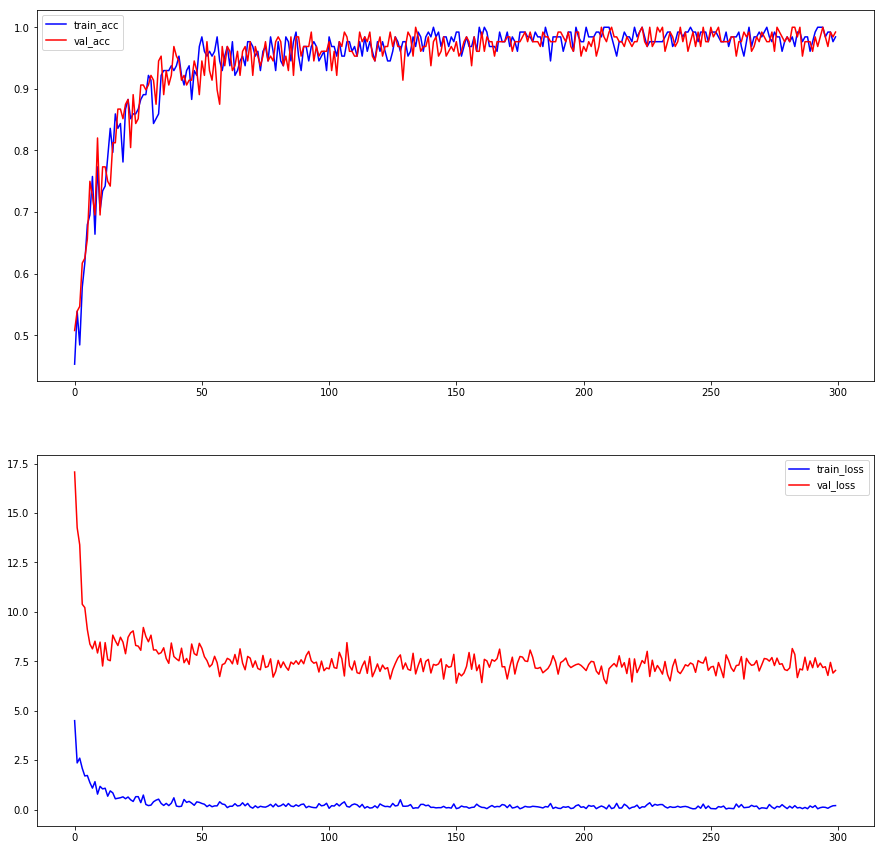

In [47]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

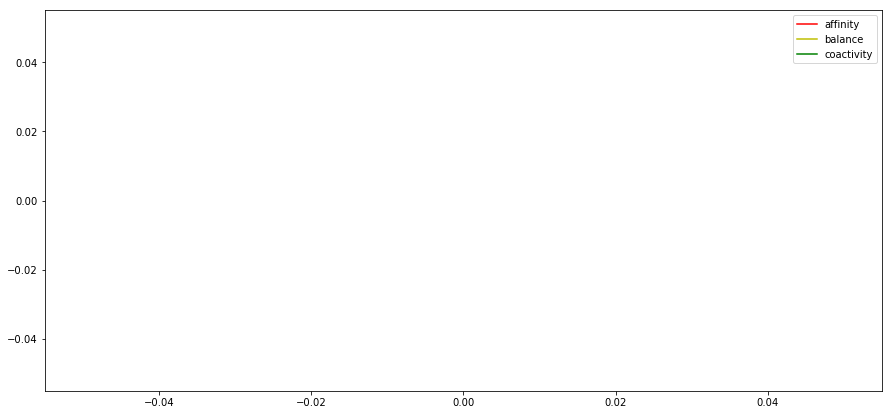

In [48]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [49]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(10)

In [50]:
#sess.run(tf.global_variables_initializer())
for i in range(1000):
    testbatch = next_batch(1,True,test_images, test_labels, test_super_labels,_epochs_completed_test,_index_in_epoch_test)
    lbl = testbatch[2].ravel()
    digitCount[np.argmax(lbl)]+=1
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1], y2_:testbatch[2]})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1], y2_:testbatch[2]})
    ypred.reshape(10)
    digitTrace[np.argmax(ypred),:] += testbatch[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [51]:
print(digitCount)
print(digitTraceCount)

[  99.  106.  116.   96.   93.   82.  101.  100.  110.   97.]
[   0.    0.    0.    0.  517.  483.    0.    0.    0.    0.]


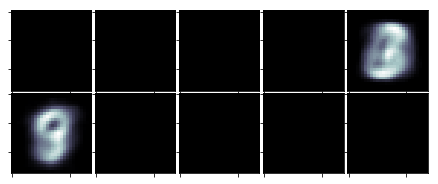

In [52]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [53]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

## Clustering score

In [54]:
testbatch = next_batch(10000,True,test_images, test_labels, test_super_labels,_epochs_completed_test,_index_in_epoch_test)
lbls = testbatch[2].reshape(10000,10)
testFeed = {x: testbatch[0], y_: testbatch[1],y2_:testbatch[2]}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((testbatch[0].shape[0],clustCount*classCount))
print(np.argmax(ypred,1).shape)
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(testbatch[2][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(lbls,1).astype('int32'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
clustAcc = accuracy
print('Clustering Accuracy: %g'%(accuracy))
print(ylookup)
print(testbatch[2].shape)

(10000,)
Clustering Accuracy: 0.2128
[0, 0, 0, 0, 1, 7, 0, 0, 0, 0]
(10000, 2, 5)


In [55]:
testbatch[2].shape

(10000, 2, 5)

In [56]:
notify("Superclass: %g \nSubclass: %g"%(testAcc,clustAcc))

## Compare it to k-means

In [ ]:
tb0 = [tb[0][np.argmax(tb[1],1)<5],tb[1][np.argmax(tb[1],1)<5]]
tb1 = [tb[0][np.argmax(tb[1],1)>4],tb[1][np.argmax(tb[1],1)>4]]
#<5
kmeans = KMeans(n_clusters=5)
km0_ypred = kmeans.fit_transform(tb0[0])
km0_ypred = np.argmax(km0_ypred,1)
km_ylookup = [np.argmax(np.sum(tb0[1][km0_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km0_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb0[1],1).astype('int32'))
km0_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
#>4
kmeans = KMeans(n_clusters=5)
km1_ypred = kmeans.fit_transform(tb1[0])
km1_ypred = np.argmax(km1_ypred,1)
km_ylookup = [np.argmax(np.sum(tb1[1][km1_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km1_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb1[1],1).astype('int32'))
km1_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print('ACOL Accuracy: %g'%(accuracy))
print('KMeans Accuracy: %g'%((km0_accuracy+km1_accuracy)/2))

In [ ]:
#visualise kmeans
digitTrace = np.concatenate([[np.sum(tb0[0][km0_ypred==i,:],axis=0) for i in range(clustCount)],
                       [np.sum(tb1[0][km1_ypred==i,:],axis=0) for i in range(clustCount)]])
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')